## Image Classification using Convolutional Neural Networks (CNNs)

#### Objective:

The objective of this exercise is to provide students with hands-on experience in building, training, and evaluating a Convolutional Neural Network (CNN) for image classification using the Caltech101 dataset. Students will learn the principles of CNNs, including convolutional layers, pooling layers, and fully connected layers, as well as techniques for data augmentation and model evaluation.

#### Dataset:

Caltech101: This dataset contains 101 categories of objects, with approximately 40 to 800 images per category. The images are of various sizes, but most are medium resolution.

## Step 1: Preparar el dataset e importar librerías

1. Download the Caltech101 dataset and organize it into training and testing sets.
2. Apply data preprocessing techniques such as resizing images to a consistent size, normalizing pixel values, and data augmentation (rotation, scaling, flipping, etc.).

### Importar las librerías

In [1]:
import tensorflow as tf
from keras import layers, models, optimizers, regularizers, Model, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import itertools
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


## Step 2: Cargar el dataset

`tfds.load`: This function loads the specified dataset. Here, it's loading the 'caltech101' dataset with version '3.0.1'.

`split=['train[:80%]','train[:20%]']`: The dataset is split into two parts: 80% for training and 20% for testing.

`with_info=True`: This flag indicates that additional metadata about the dataset should be returned, such as the number of classes.

`as_supervised=True`: This ensures that the data is returned as a tuple (image, label) rather than a dictionary. This format is typical for supervised learning tasks.

`download=False`: This prevents the code from downloading the dataset if it is not already available locally.

In [9]:
# cargar el dataset caltech101
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101',
    split=['train[:80%]','test[:20%]'], #division del dataset: 80% para entrenamiento, 20% para prueba
    with_info=True,
    as_supervised=True,
    data_dir='/content/drive/MyDrive/RI',
    download=False # cambiar a true para descargar el dataset si no esta disponible
)

## Step 3: Preprocesar los datos

`tf.image.resize(image, (224, 224))`: Resizes each image to 224x224 pixels. This is a common size for CNN inputs, such as those used in models like VGG and ResNet.

`tf.cast(image, tf.float32) / 255.0`: Converts the pixel values to float32 and normalizes them to the range [0, 1]. This normalization helps improve the convergence of neural networks during training.

In [10]:
num_classes = dataset_info.features['label'].num_classes

def preprocess_image(image, label):
    # redimensionar la imagen
    image = tf.image.resize(image, (56, 56))
    # normalizar la imagen
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

train_dataset = (train_dataset.map(preprocess_image)
                              .shuffle(1000)  # aleatorizar el orden de las imagenes
                              .batch(32)      # agrupar en lotes de 32 imagenes
                              .prefetch(tf.data.experimental.AUTOTUNE))  # optimizar el rendimiento

test_dataset = (test_dataset.map(preprocess_image)
                              .batch(32)      # agrupar en lotes de 32 imagenes
                              .prefetch(tf.data.experimental.AUTOTUNE))  # optimizar el rendimiento

## Step 4: Construir el modelo de entrenamiento

`models.Sequential`: This specifies a linear stack of layers. The layers are added sequentially, meaning each layer has exactly one input tensor and one output tensor.

`layers.Conv2D(32, (3, 3), activation='relu')`: This layer creates 32 filters, each of size 3x3, which convolve over the input image. The activation function used is ReLU (Rectified Linear Unit), which introduces non-linearity into the model.
input_shape=(224, 224, 3): Specifies the input shape, where 224x224 is the image size and 3 is the number of color channels (RGB).

`layers.MaxPooling2D((2, 2))`: This layer performs max pooling with a 2x2 filter, reducing the spatial dimensions (height and width) by half. It helps in reducing the computational complexity and the risk of overfitting by down-sampling the input.

`layers.Conv2D(64, (3, 3), activation='relu')`: This layer increases the number of filters to 64, with each filter of size 3x3. This deeper layer can learn more complex features.

`layers.Flatten()`: This layer flattens the 2D outputs from the previous layer into a 1D vector, preparing the data for the fully connected layers.

`layers.Dense(128, activation='relu')`: A dense layer with 128 units and ReLU activation. Dense layers are fully connected, meaning each neuron in the layer receives input from all neurons in the previous layer. This layer helps in learning complex

`layers.Dense(num_classes, activation='softmax')`: The output layer with a number of units equal to the number of classes (num_classes). The softmax activation function is used, which outputs a probability distribution over the classes, making it suitable for multi-class classification.

In [14]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(56, 56, 3)), #primera capa de convolucion con 32 filtros de tamaño 3x3 y funcion de activacion Relu.
    layers.Conv2D(32, (3, 3), activation='relu'), #segunda capa de convolucion con 32 filtros de tamaño 3x3 y funcion de activacion Relu.
    layers.MaxPooling2D((2, 2)), #capa de max pooling con ventanas de 2x2 para reducir las dimensiones espaciales.

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax') #se utiliza la funcion de activación softmax para obtener probabilidades de clasificacion.

])

## Step 5: Compilar y entrenar el modelo

`optimizer='adam'`: The Adam (Adaptive Moment Estimation) optimizer is used to adjust the model's weights during training. Adam is a popular choice because it combines the advantages of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). It adapts the learning rate for each parameter, making the optimization process more efficient and potentially leading to faster convergence.

`loss='sparse_categorical_crossentropy'`: This loss function is used for multi-class classification problems where the target labels are integers. In this case, the labels are provided as integers (e.g., 0, 1, 2, ...) rather than one-hot encoded vectors. The sparse categorical crossentropy computes the cross-entropy loss between the true labels and the predicted probabilities, which is suitable for multi-class classification tasks.

`metrics=['accuracy']`: This specifies that accuracy will be tracked during training and evaluation. Accuracy is a common metric for classification tasks, representing the proportion of correctly predicted samples.

In [15]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001), #optimizar con Adam con una tasa de aprendizaje inicial de 0.0001
    loss='sparse_categorical_crossentropy', #funcion de perdida para clasificacion multiclase con etiquetas enteras
    metrics=['accuracy'] #metrica para evaluar el rendimiento del modelo durante el entrenamiento y prueba
)
 #Callback para reducir el learning rate si no hay mejoras
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

In [17]:
history = model.fit(train_dataset, #dataset de entrenamiento
                    epochs=15, #numero de epocas para entrenar el modelo+
                    validation_data=test_dataset #dataset de validacion para evaluar el modelo en cada epoca
                    , callbacks=[reduce_lr])

Epoch 1/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 51s 652ms/step - accuracy: 0.3977 - loss: 2.8232 - val_accuracy: 0.4314 - val_loss: 2.9049 - learning_rate: 1.0000e-04
Epoch 2/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 78s 612ms/step - accuracy: 0.4326 - loss: 2.6390 - val_accuracy: 0.4248 - val_loss: 2.8249 - learning_rate: 1.0000e-04
Epoch 3/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 76s 530ms/step - accuracy: 0.4578 - loss: 2.5107 - val_accuracy: 0.4585 - val_loss: 2.7657 - learning_rate: 1.0000e-04
Epoch 4/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 42s 542ms/step - accuracy: 0.5113 - loss: 2.1951 - val_accuracy: 0.4503 - val_loss: 2.8070 - learning_rate: 1.0000e-04
Epoch 5/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 539ms/step - accuracy: 0.5564 - loss: 2.0619 - val_accuracy: 0.4478 - val_loss: 2.8205 - learning_rate: 1.0000e-04
Epoch 6/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 516ms/step - accuracy: 0.5658 - loss: 1.8778 - val_accuracy: 0.4692 - val_loss: 2.6972 - learning_rate: 1.0000e-04
Epoch 7/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 43s 538ms/step - acc

### Número de parametro entrenables

In [18]:
num_params = model.count_params()
print(f"Number of trainable parameters in the model: {num_params}")

Number of trainable parameters in the model: 1781638


## Evaluar e interpretar
- Evaluate the model's performance on the testing dataset and calculate the accuracy.
- Visualize some misclassified images and discuss the possible reasons for misclassifications.

### Precisión del modelo

In [19]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.4830 - loss: 2.9956
Accuracy on the test set: 46.75%


### Gráficas de las métricas de pérdida y precisión del modelo

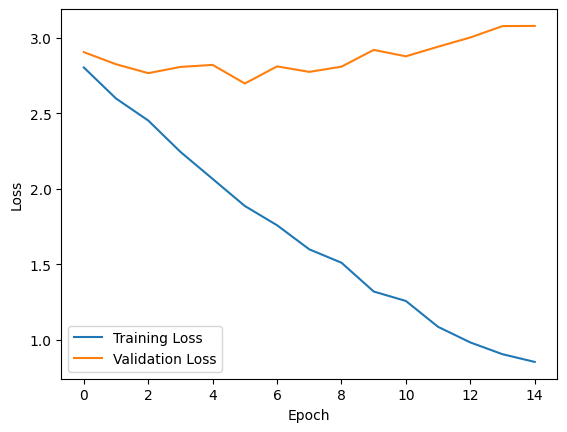

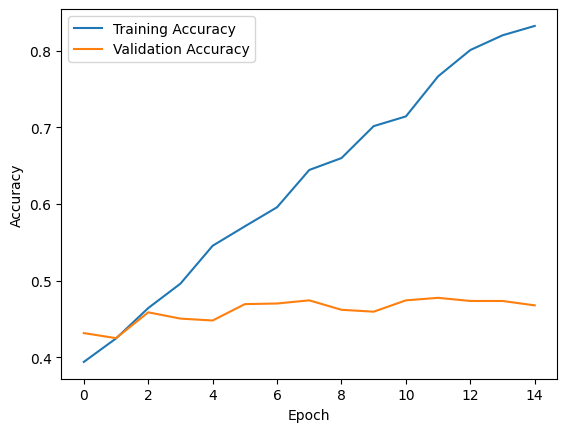

In [20]:
#grafica de la perdida
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#grafica de la precision
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Imágenes mal clasificadas por el modelo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

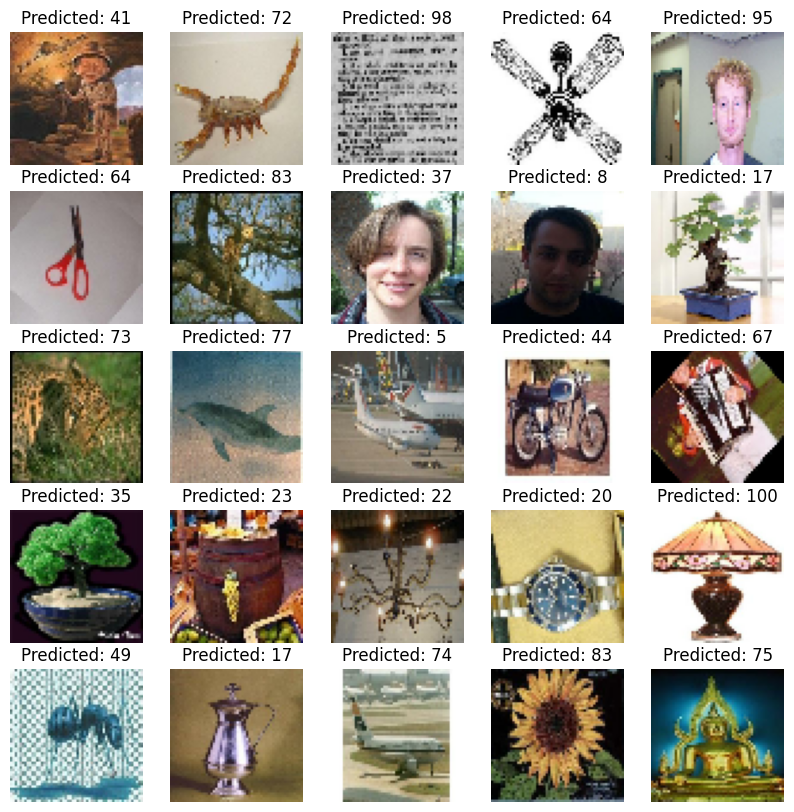

In [22]:
misclassified_images = []
misclassified_labels = []
for image, label in test_dataset:
    #realizar predicciones para el lote actual de imagenes
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    misclassified_idx = np.where(predicted_label != label.numpy())[0] #encontrar indices mal clasificados
    for idx in misclassified_idx:
        misclassified_images.append(image[idx])
        misclassified_labels.append(predicted_label[idx])

#numero de imagenes mal clasificadas a mostrar
num_images_to_show = min(len(misclassified_images), 25)
plt.figure(figsize=(10, 10))

#mostrar cada imagen mal clasificada en una cuadricula
for i in range(num_images_to_show):
    plt.subplot(5, 5, i+1)
    plt.imshow(misclassified_images[i])
    plt.title(f"Predicted: {misclassified_labels[i]}")
    plt.axis('off')

plt.show()

### Imágenes bien clasificadas por el modelo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

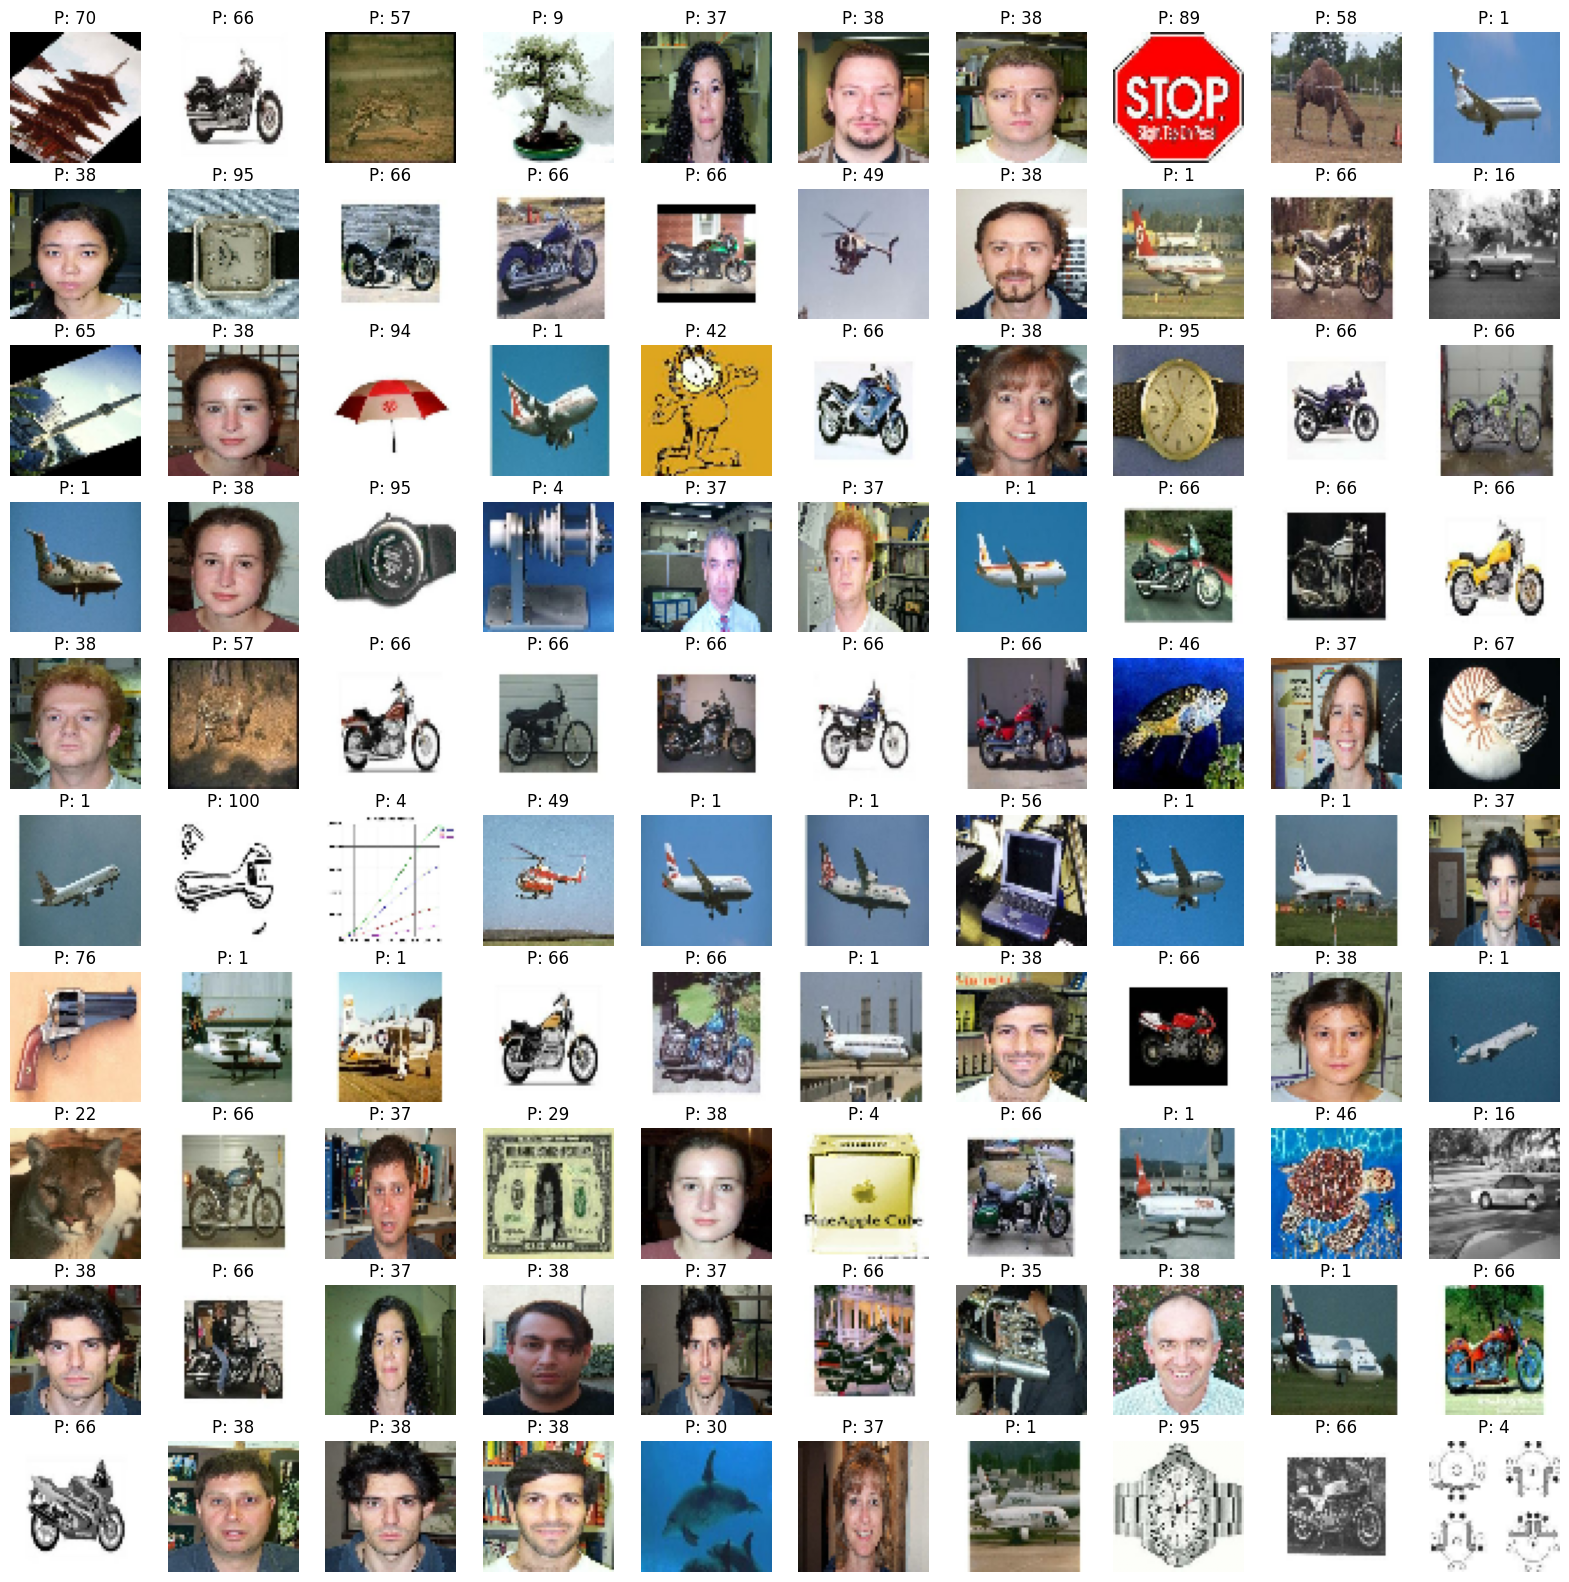

In [24]:
niceclassified_images = []
niceclassified_labels = []

for image, label in test_dataset:
    #realizar predicciones para el lote actual de imagenes
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    niceclassified_idx = np.where(predicted_label == label.numpy())[0] #encontrar indices bien clasificados
    for idx in niceclassified_idx:
        niceclassified_images.append(image[idx])
        niceclassified_labels.append(predicted_label[idx])

#numero de imagenes mal clasificadas a mostrar
num_images_to_show = min(len(niceclassified_images), 100)
plt.figure(figsize=(20, 20))

#mostrar cada imagen mal clasificada en una cuadricula
for i in range(num_images_to_show):
    plt.subplot(10, 10, i+1)
    plt.imshow(niceclassified_images[i])
    plt.title(f"P: {niceclassified_labels[i]}")
    plt.axis('off')

plt.show()